# Project Report 1_Xiangrong(Daniel)Zhu

This is the report of project 1. You can check the development process of the code record.py here. If you want to test the code more directly, it might be more convenient to directly run 'python record.py' in terminal/PowerShell.

## Requirements

Write a program to capture speech data. It must include the following:

• Actual speech capture. The captured speech signals must have 16-bit 
resolution, mono channel and be captured at a sampling rate of 16000 
samples per second. If you're one of the unfortunates stuck with working 
on a Mac, you may use a sampling rate of 44100 instead.

• Endpointing, with hit-to-talk. Recording must begin at a keyboard hit, 
and stop automatically when end of speech is detected. You may use one 
of the endpointing schemes mentioned in the lecture to find the trailing 
endpoint, or any other method you may come up with.

• The endpointed segment must be written to file in ms wav or raw pcm 
format.

## Implementation

### Actual Speech Capture

Record a 10-sec sound data and store it into 'sample_recording.wav' for future analysis.

In [12]:
import pyaudio
import wave
import numpy as np

chunk = 1024      # Each chunk will consist of 1024 samples
sample_format = pyaudio.paInt16      # 16 bits per sample
channels = 1      # Number of audio channels
fs = 16000        # Record at 16000 samples per second
time_in_seconds = 10
filename = "sample_recording.wav"
 
p = pyaudio.PyAudio()  # Create an interface to PortAudio
 
print('-----Now Recording-----')
 
#Open a Stream with the values we just defined
stream = p.open(format=sample_format,
                channels = channels,
                rate = fs,
                frames_per_buffer = chunk,
                input = True)
 
frames = []  # Initialize array to store frames

for i in range(int(fs/chunk*time_in_seconds)):
    data = stream.read(chunk)
    frames.append(data)
# Stop and close the Stream and PyAudio
print('-----Finished Recording-----')
 
# Open and Set the data of the WAV file
file = wave.open(filename, 'wb')
file.setnchannels(channels)
file.setsampwidth(p.get_sample_size(sample_format))
file.setframerate(fs)
 
#Write and Close the File
file.writeframes(b''.join(frames))
file.close()

-----Now Recording-----
-----Finished Recording-----


Plot the raw sound wave data and visulize it.

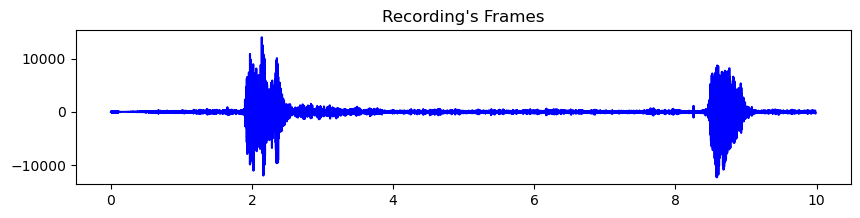

In [13]:
#import
import wave as we
import numpy as np
import matplotlib.pyplot as plt

def wavread(path):
    wavfile =  we.open(path,"rb")
    params = wavfile.getparams()
    framesra,frameswav= params[2],params[3]
    datawav = wavfile.readframes(frameswav)
    wavfile.close()
    datause = np.frombuffer(datawav,dtype = np.short)
    datause.shape = -1,1
    datause = datause.T
    time = np.arange(0, frameswav) * (1.0/framesra)
    return datause,time

def plot():
    path = 'sample_recording.wav'
    wavdata,wavtime = wavread(path)
    fig = plt.figure(figsize=(10, 2))
    plt.title("Recording's Frames")
    plt.plot(wavtime, wavdata[0], color = 'blue')
    plt.show()

plot()

Segment the raw data array into 1024-sample frames (originally set to be 320-sample, but a 1024-sample frame segmentation is more convenient when doing real-time endpoint detection task later because data was orinigally stored into 1024-sample frames), and calculate the energy (volume) of corresponding frames for endpoint detection.

In [14]:
import math
path = 'sample_recording.wav'
framelen = 1024

test = True
wavdata,wavtime = wavread(path)
raw = wavdata[0].tolist()
energy = []
energy_log = []
rep = len(raw)
for pointer_raw in range(0,rep,framelen):
    energy_frame = 0
    #print(mean)
    for i in range(framelen):
        energy_frame += (raw[i + pointer_raw]) ** 2
        #energy_frame += (mean) ** 2
        #print(energy_frame)
    if energy_frame!=0:
        energy_log.append(math.log10(energy_frame))
        energy.append(energy_frame)
    else:
        energy.append(0.0)
        energy_log.append(0.0)

Visualize the results of energy, 10**energy, and orignial wave on one graph (note that the graph has 3 different y-labels, it only represents proportion rather than absolute value).

(Green: 10**energy; red: energy; blue: raw sound wave data)

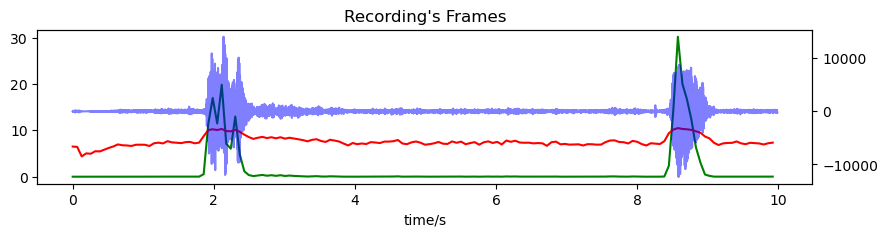

In [15]:
l = len(energy)
index = []
for i in range (l):
    index.append(i/16000*1024)
#fig = plt.figure(figsize=(10, 2))

fig,ax1 = plt.subplots(figsize = (10,2))
ax2 = ax1.twinx() 
plot_energy = []
for item in energy:
    plot_energy.append(item/10**9)
plt.title("Recording's Frames")
ax2.plot(wavtime, wavdata[0], color = 'blue', alpha = 0.5)
ax1.plot(index, plot_energy, color = 'green')
ax1.plot(index, energy_log, color = 'red')
#ax1.set_ylabel('without_log',color = 'green')   #设置Y1轴标题
#ax2.set_ylabel('with_log',color = 'red')
ax1.set_xlabel('time/s')
#ax1.legend('without log')
#ax2.legend('with log')
plt.show()

It is trivial that the energy (after log) is very sensitive to low-volume sound (see 0s-0.5s), yet energy without log (10**energy) is very sensitive to high-volume sound.

### Endpoint detection

One-threshold algorithm for detecting endpoints.

In [16]:
def endpoint(data,forget_factor, adjustment, threshold):
    # set initial background value to the sum of first 10 frames
    background = part_sum(0,10,data)
    IsSpeech = []    
    # det represents the value that is compared to threshold everytime (in this one-threshold case), it is recorded for determining threshold.
    det = []

    level = data[0]
    for current in range(len(data)):
        is_speech = 0

        # applying the algorithm from PPT, set a smoothed index to indicate the status of current frame
        level = ((level*forget_factor) + data[current])/(forget_factor+1)
        
        # if current volume is smaller than the background noise, it means that it is not a speech.
        if data[current] < background:
            background = data[current]
        else:
        # adjust the background according to adjustent index in order to be adaptive to instableness of envir noises
            background += (data[current]-background) * adjustment
        
        # if the smoothed level of current frame is smaller than background, we want to set the determining factor (level-background) to 0
        if level < background:
            level = background
        
        # determine the variance in smoothed index over background noise can be classified as a speech or not
        if (level-background) > threshold:
            is_speech = 1
    
        det.append(level-background)
        IsSpeech.append(is_speech)

    return IsSpeech, det
def main(data, forget_factor, adjustment, threshold):
    Speech = []
    Silence = []

    # IsSpeech is a list of 1/0 index that indicate if the corresponding frame is speech or not
    IsSpeech, det = endpoint(data, forget_factor, adjustment, threshold)
    
    # Create X-values for plotting the graph
    for i in range(len(data)):
        Speech.append(IsSpeech[i]*data[i])
        Silence.append((1-IsSpeech[i])*data[i])
    Speech, Silence = remove_zero(Speech, Silence)
    
    fig,ax1 = plt.subplots(figsize = (10,2))
    ax2 = ax1.twinx() 
    plot_energy = []
    plt.title("Endpoint Detection")
    ax2.plot(wavtime, wavdata[0], color = 'blue', alpha = 0.5)
    ax1.plot(index, IsSpeech, color = 'red')
    ax1.set_xlabel('time/s')

    # Create threshold data for plotting the threshold line on the graph
    y_thres = []
    for i in range(len(index)):
        y_thres.append(threshold)

    plt.figure(figsize=(10, 2))
    plt.title("Threshold determination")
    plt.plot(index, det, color = 'green')
    plt.plot(index, y_thres, color = 'red')
    plt.show()
# function that helps remove zeros in Speech and Silence list for plotting
def remove_zero(L1, L2):
    for i in range(len(L1)-1):
        # We want the curve to be continous, so we want to append a previous value ahead of the first 0->1 or 1->0
        # elsewise the graph will not be continuous
        if L1[i] == 0:
            if L1[i+1]!= 0:
                L1[i] = L2[i]
            else:
                L1[i] = None    
        if L2[i] == 0:
            if L2[i+1]!= 0:
                L2[i] = L1[i]
            else:
                L2[i] = None 
        
    return L1, L2
# function that returns the sum of given digit range of a list
def part_sum(start,end,target):
    sum = 0
    for i in range(start,end):
        sum += target[i]
    return sum
# function that helps to plot the energy curve (blue is determined as sound and red as silence)
def main_sq(data,forget_factor, adjustment, threshold):
    Speech = []
    Silence = []

    IsSpeech, det = endpoint(data, forget_factor, adjustment, threshold)
    for i in range(len(data)):
        Speech.append(IsSpeech[i]*data[i])
        Silence.append((1-IsSpeech[i])*data[i])
    

    Speech, Silence = remove_zero(Speech, Silence)
    plt.figure(figsize=(10, 2))
    plt.title("Energy Curve")
    plt.plot(index, Speech, color = 'blue')
    plt.plot(index, Silence, color = 'red')
    
    plt.show()

Parameter determination of energy with log (DBs).

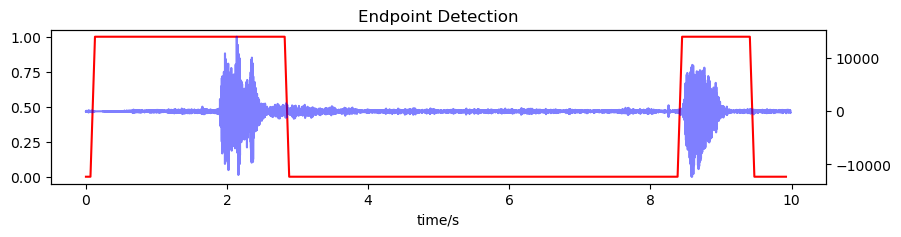

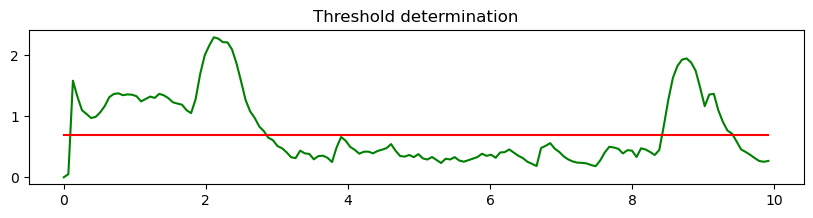

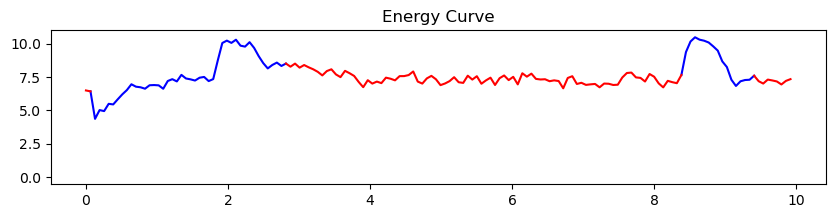

In [29]:
forget = 3
adjust = 0.05
thold = 0.7

main(energy_log,forget_factor=forget, adjustment=adjust, threshold=thold)
main_sq(energy_log,forget_factor=forget, adjustment=adjust, threshold=thold)

Parameter determination of energy without log (10**DBs).

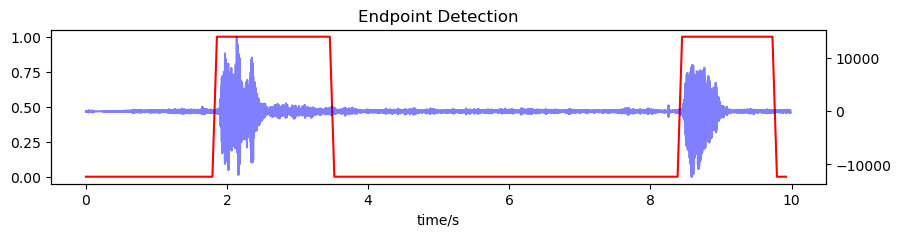

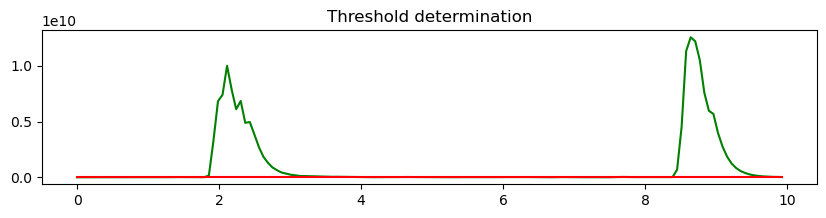

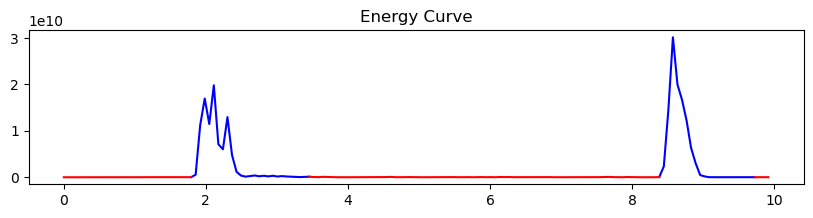

In [25]:
main(energy,forget_factor = 2, adjustment = 0.05, threshold= 5*10**7)
main_sq(energy,forget_factor = 2, adjustment = 0.05, threshold= 5*10**7)

Pack all the function into check_stop function that returns whether we should end the recording.

In [ ]:
def endpoint(data,forget_factor, adjustment, threshold):
    background = part_sum(0,10,data)
    IsSpeech = []    
    det = []

    level = data[0]
    for current in range(len(data)):
        is_speech = 0
        level = ((level*forget_factor) + data[current])/(forget_factor+1)
        
        if data[current] < background:
            background = data[current]
        else:
            background += (data[current]-background) * adjustment
        
        if level < background:
            level = background
        
        #print(level-background)
        
        if (level-background) > threshold:
            is_speech = 1
        
        det.append(level-background)
        IsSpeech.append(is_speech)

    return IsSpeech, det

def check_stop(stop_count, frame_data,frame_len):
    en, en_log = energy(frame_data,frame_len)
    IsSpeech, det = endpoint(en,forget_factor = 2, adjustment = 0.05, threshold= 5.4*10**6)
#   IsSpeech, det = endpoint(en_log, forget_factor=3, adjustment=0.05, threshold=0.36)
    check = 0
    for i in range(len(IsSpeech)-20,len(IsSpeech)):
        check += IsSpeech[i]
    if check == 0:
        return True
    return False

def energy(frame_data,frame_len):
    temp_en = 0
    en, en_log = [], []
    for i in range(0,len(frame_data),frame_len):
        for j in range(frame_len):
            temp_en += frame_data[i+j]**2
        if temp_en == 0:
            en.append(0.0)
            en_log.append(0.0)
        else:
            en.append(temp_en)
            en_log.append(math.log10(temp_en))
    return(en,en_log)

Full code of real-time endpoint detection (without hit-to-start).

In [ ]:
p = pyaudio.PyAudio()  # Create an interface to PortAudio
 
print('-----Now Recording-----')
 
#Open a Stream with the values we just defined
stream = p.open(format=sample_format,
                channels = channels,
                rate = fs,
                frames_per_buffer = chunk,
                input = True)
 
frames = []  # Initialize array to store frames
frame_data = []
loop = True
# Store data in chunks for 10 seconds

for i in range(20):
    data = stream.read(chunk)
    frames.append(data)
    rt_data = np.frombuffer(data, np.dtype('<i2'))
    rt_data.shape = -1,1
    rt_data = rt_data.T[0].tolist()
    frame_data += rt_data
    #print(len(frame_data)/1024)

while loop:
    data = stream.read(chunk)
    frames.append(data)
    
    rt_data = np.frombuffer(data, np.dtype('<i2'))
    rt_data.shape = -1,1
    rt_data = rt_data.T[0].tolist()
    frame_data +=rt_data
    #print(len(frame_data)/1024)
    if check_stop(frame_data,1024):
        stream.stop_stream()
        stream.close()
        p.terminate()
        loop = False
    else:
        loop = True
    #print(rt_data.shape)
    
 
# Stop and close the Stream and PyAudio

 
print('-----Finished Recording-----')
 
# Open and Set the data of the WAV file
file = wave.open(filename, 'wb')
file.setnchannels(channels)
file.setsampwidth(p.get_sample_size(sample_format))
file.setframerate(fs)
 
#Write and Close the File
file.writeframes(b''.join(frames))
file.close()